In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from torch import nn
import sklearn

# Making a Toy Classification Dataset

In [2]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
#Make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


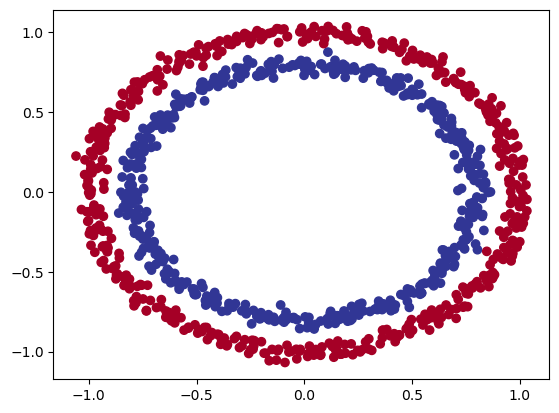

In [5]:
#Visualize
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

# Turning our Data into Tensors & Making a Training & Test Split

In [6]:
#Check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
#Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [9]:
#Random train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Laying Out Steps for Modeling & Setting Up Device-Agnostic Code

In [10]:
#Device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Coding a Small Neural Network to Handle our Classification Data

In [11]:
#Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #Create 2 nn.Linear layers that can handle the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #2 input features, upscaled to 5 features, outputs 1 feature
        self.layer_2 = nn.Linear(in_features=5, out_features=1) #in_features of a layer must match out_features of the previous layer
    
    #Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) #x -> layer_1 -> layer_2 -> output
    
#Instantiate our model class & send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

# Making Our Neural Network Visual

In [12]:
#Illustrated playground.tensorflow.org

# Recreating & Exploring the Insides of our Model using nn.Sequential

In [13]:
#Note this creates the same model as defined above (CircleModelV0)
#####################################################################################
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
#####################################################################################
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_0.state_dict() #two weight tensors and two bias tensors

OrderedDict([('0.weight',
              tensor([[-0.3975, -0.5669],
                      [-0.3191, -0.2979],
                      [ 0.2069, -0.2275],
                      [ 0.3094, -0.6949],
                      [ 0.0376,  0.1828]])),
             ('0.bias', tensor([-0.5171, -0.2934,  0.5985, -0.6635, -0.5023])),
             ('1.weight',
              tensor([[ 0.2844, -0.4228,  0.0099,  0.3980, -0.4014]])),
             ('1.bias', tensor([0.3704]))])

In [15]:
#Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.0231],
        [-0.0790],
        [ 0.3201],
        [-0.1211],
        [ 0.6322],
        [ 0.5957],
        [ 0.1908],
        [ 0.3496],
        [ 0.3065],
        [-0.0793]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Loss Function, Optimizer, & Evaluation Function for our Classification Network

In [16]:
#We will use torch.nn.BCEWithLogitsLoss (BCE=binary cross entropy)
loss_fn = nn.BCEWithLogitsLoss() #uses sigmoid activation function built in
#Note that nn.BCELoss() requires inputs to have gone through the sigmoid activation function prior to BCELoss

In [17]:
#Setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [18]:
#Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    #torch.eq counts how many of one object are equal to the other object
    acc = (correct/len(y_pred)) * 100
    return acc

# Going From Model Logits to Prediction Probabilities to Prediction Labels

In [19]:
#Train model
#Remember the steps of the training loop:
#1. Forward pass
#2. Calculate loss
#3. Optimizer zero grad
#4. Loss backward (backpropagation)
#5. Optimizer step (gradient descent)

In [20]:
#Our model outputs with BCEWithLogitsLoss() will be raw logits

#We can convert these logits into prediction probabilities by passing them through an activation function
#(sigmoid for binary classification and softmax for multiclass classification)

#Then we convert the prediction probabilities to prediction labels by either rounding or taking the argmax()

In [21]:
#View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.0231],
        [-0.0790],
        [ 0.3201],
        [-0.1211],
        [ 0.6322]])

In [22]:
#Use the sigmoid activation function on our model logits to get prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4942],
        [0.4803],
        [0.5794],
        [0.4698],
        [0.6530]])

In [23]:
#Round to get prediction labels
y_preds = torch.round(y_pred_probs)
y_preds[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [24]:
#Go from logits to probabilities to labels in one line of code
model_0.eval()
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

# Coding a Training & Testing Optimization Loop for our Classification Model

In [25]:
torch.manual_seed(42)

epochs = 100

#Put data on the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

#Training Loop############################
for epoch in range(epochs):
    model_0.train()
    
    #1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) #We pass in logits here since we are using BCEWithLogitsLoss
    #Note BCELoss() expects prediction probabilities as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Loss backward (Backpropagation)
    loss.backward()
    
    #5. Optimizer step (gradient descent)
    optimizer.step()
    
    #Testing loop#########################
    model_0.eval()
    with torch.inference_mode():
        
        #1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        #2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    #Print current values
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71438 | Acc: 54.12% | Test Loss: 0.70195 | Test acc: 59.00%
Epoch: 10 | Loss: 0.70501 | Acc: 51.75% | Test Loss: 0.69535 | Test acc: 51.00%
Epoch: 20 | Loss: 0.70128 | Acc: 51.00% | Test Loss: 0.69334 | Test acc: 52.00%
Epoch: 30 | Loss: 0.69919 | Acc: 50.12% | Test Loss: 0.69256 | Test acc: 52.00%
Epoch: 40 | Loss: 0.69776 | Acc: 50.38% | Test Loss: 0.69221 | Test acc: 50.50%
Epoch: 50 | Loss: 0.69671 | Acc: 50.25% | Test Loss: 0.69208 | Test acc: 51.00%
Epoch: 60 | Loss: 0.69590 | Acc: 50.12% | Test Loss: 0.69206 | Test acc: 51.50%
Epoch: 70 | Loss: 0.69528 | Acc: 50.12% | Test Loss: 0.69213 | Test acc: 51.00%
Epoch: 80 | Loss: 0.69480 | Acc: 50.25% | Test Loss: 0.69224 | Test acc: 50.00%
Epoch: 90 | Loss: 0.69442 | Acc: 50.75% | Test Loss: 0.69238 | Test acc: 50.00%


# Writing Code to Download a Helper Function to Visualize our Model Predictions

In [26]:
#Make predictions & model evaluation
#Import helper function
import requests
from pathlib import Path

#Download helper functions 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else: 
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


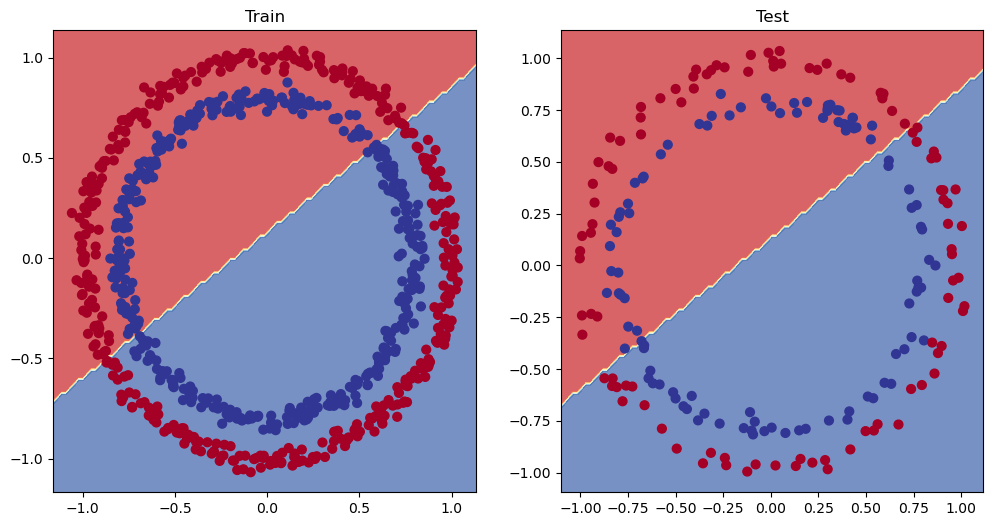

In [27]:
#Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Discussing Options to Improve a Model

In [28]:
#Ways to improve a model:

#Add more layers
#Add more hidden units
#Fit for longer (more epochs)
#Changing the activation functions
#Change the learning rate
#Change the loss function
#Change the optimization function

# Creating a New Model with More Layers & Hidden Units

In [29]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

# Writing Training & Testing Code to see if our Upgraded Model Performs Better

In [30]:
#Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

#Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [31]:
#Write a training and evaluation loop for model_1
torch.manual_seed(42)

epochs = 1000

#Put data onto target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

###Training loop###
for epoch in range(epochs):
    model_1.train()
    
    #1. Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Loss backward (Backpropagation)
    loss.backward()
    
    #5. Optimizer step (gradient descent)
    optimizer.step()
    
    ###Testing loop###
    model_1.eval()
    with torch.inference_mode():
        #1. Forward Pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        #2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    #Print out current values
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261 | Test acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test Loss: 0.69379 | Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test Loss: 0.69437 | Test acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62% | Test Loss: 0.69458 | Test acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12% | Test Loss: 0.69465 | Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69467 | Test acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test acc: 46.00%


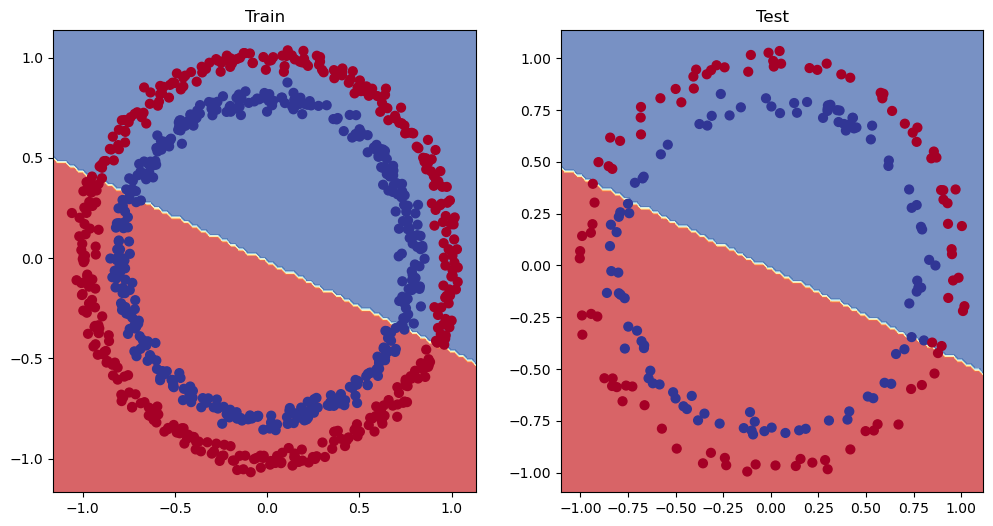

In [32]:
#Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Creating a Straight Line Dataset to see if our Model is Learning Anything

In [33]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
#Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

#Check data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [34]:
#Create training and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, 
                                                                    y_regression, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

len(X_train_reg), len(X_test_reg)

(80, 20)

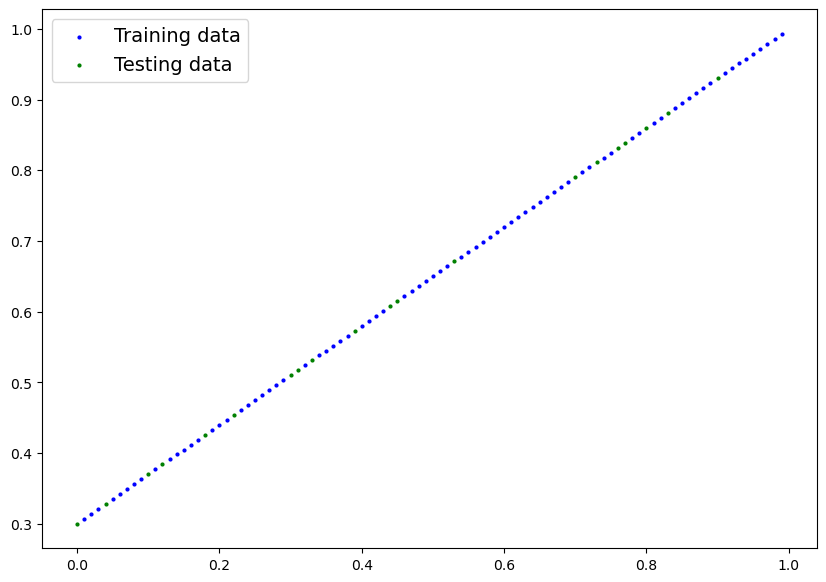

In [35]:
plot_predictions(train_data=X_train_reg, 
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg);

# Building & Training a Model to Fit on Straight Line Data

In [36]:
#Adjusting model_1 since straight line data only has 1 feature instead of 2 features
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
#Loss function & optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [38]:
#Training & Testing Loop
#Write a training and evaluation loop for model_1
torch.manual_seed(42)

epochs = 1000

#Put data onto target device
X_train_reg = X_train_reg.to(device)
X_test_reg = X_test_reg.to(device)
y_train_reg = y_train_reg.to(device)
y_test_reg = y_test_reg.to(device)

###Training loop###
for epoch in range(epochs):
    model_2.train()
    
    #1. Forward Pass
    y_pred = model_2(X_train_reg)
    
    #2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y_train_reg)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Loss backward (Backpropagation)
    loss.backward()
    
    #5. Optimizer step (gradient descent)
    optimizer.step()
    
    ###Testing loop###
    model_2.eval()
    with torch.inference_mode():
        #1. Forward Pass
        test_pred = model_2(X_test_reg)
        
        #2. Calculate loss/accuracy
        test_loss = loss_fn(test_pred, y_test_reg)
        
    #Print out current values
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.80353 | Test Loss: 0.73955
Epoch: 100 | Loss: 0.02930 | Test Loss: 0.01250
Epoch: 200 | Loss: 0.02346 | Test Loss: 0.01752
Epoch: 300 | Loss: 0.02341 | Test Loss: 0.01660
Epoch: 400 | Loss: 0.02382 | Test Loss: 0.01524
Epoch: 500 | Loss: 0.02303 | Test Loss: 0.01515
Epoch: 600 | Loss: 0.02270 | Test Loss: 0.01460
Epoch: 700 | Loss: 0.02148 | Test Loss: 0.01497
Epoch: 800 | Loss: 0.02129 | Test Loss: 0.01444
Epoch: 900 | Loss: 0.02147 | Test Loss: 0.01353


# Evaluating Our Model's Predictions on Straight Line Data

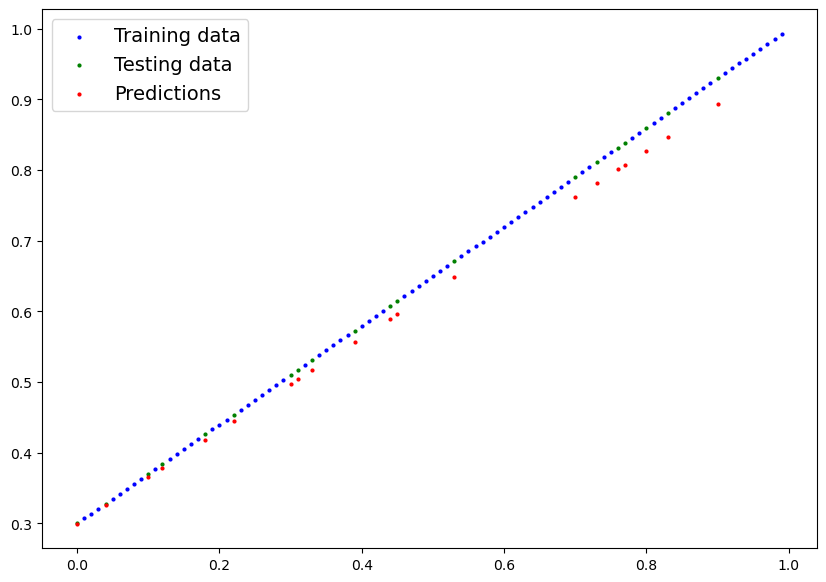

In [39]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_reg)
    
#Plot data & predictions
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg,
                predictions=y_preds);

# Introducing the Missing Piece for our Classification Model: Non-Linearity

# Building our First Neural Network with Non-Linearity


In [40]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu    = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

# Writing Training & Testing Code for our First Non-Linear Model

In [41]:
#Loss function & optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [42]:
#Training & Testing Loop
torch.manual_seed(42)

#Move data to device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

#Train
epochs = 2100

for epoch in range(epochs):
    model_3.train()
    
    #1. Forward Pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc  = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Loss backward (backpropagation)
    loss.backward()
    
    #5. Optimizer step (gradient descent)
    optimizer.step()
    
    ##Testing
    model_3.eval()
    with torch.inference_mode():
        #1. Forward Pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        #2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc  = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    #Print current values
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test Loss: 0.69319 | Test acc: 50.00%
Epoch: 100 | Loss: 0.69115 | Acc: 52.88% | Test Loss: 0.69102 | Test acc: 52.50%
Epoch: 200 | Loss: 0.68977 | Acc: 53.37% | Test Loss: 0.68940 | Test acc: 55.00%
Epoch: 300 | Loss: 0.68795 | Acc: 53.00% | Test Loss: 0.68723 | Test acc: 56.00%
Epoch: 400 | Loss: 0.68517 | Acc: 52.75% | Test Loss: 0.68411 | Test acc: 56.50%
Epoch: 500 | Loss: 0.68102 | Acc: 52.75% | Test Loss: 0.67941 | Test acc: 56.50%
Epoch: 600 | Loss: 0.67515 | Acc: 54.50% | Test Loss: 0.67285 | Test acc: 56.00%
Epoch: 700 | Loss: 0.66659 | Acc: 58.38% | Test Loss: 0.66322 | Test acc: 59.00%
Epoch: 800 | Loss: 0.65160 | Acc: 64.00% | Test Loss: 0.64757 | Test acc: 67.50%
Epoch: 900 | Loss: 0.62362 | Acc: 74.00% | Test Loss: 0.62145 | Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818 | Acc: 87.75% | Test Loss: 0.57378 | Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153 | Acc: 93.50% | Test Loss: 0.49935 | Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056 

# Making Predictions with & Evaluating our First Non-Linear Model

In [43]:
#Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

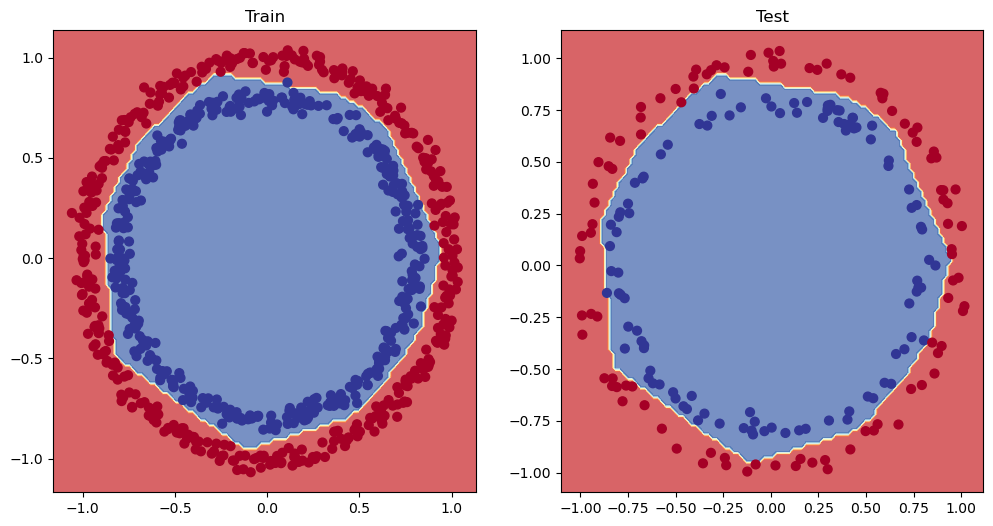

In [44]:
#plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Replicating Non-Linear Activation Functions with Pure PyTorch

In [45]:
#Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

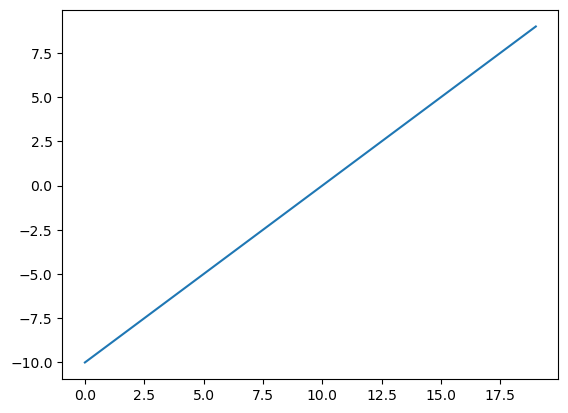

In [46]:
#Visualize tensor
plt.plot(A)

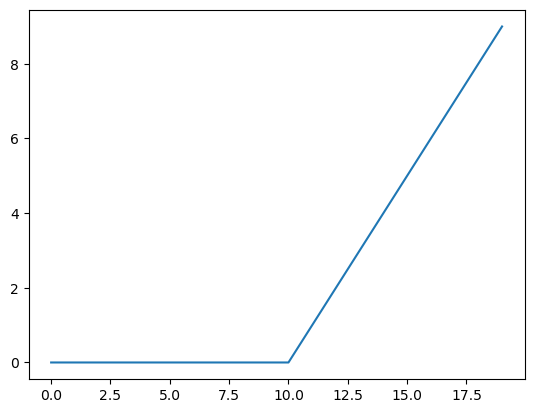

In [47]:
plt.plot(torch.relu(A))

In [48]:
#Create relu function by hand
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

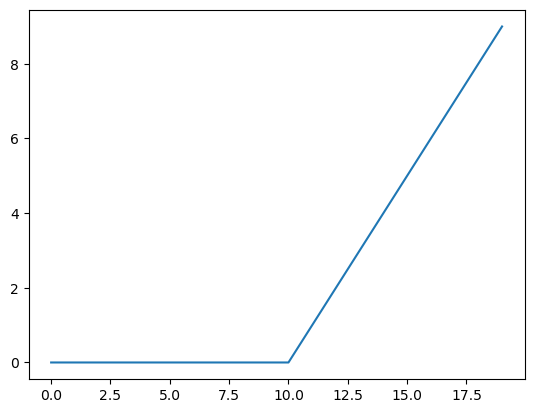

In [49]:
plt.plot(relu(A))

In [50]:
#Create sigmoid function by hand
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1/(1 + torch.exp(-x))

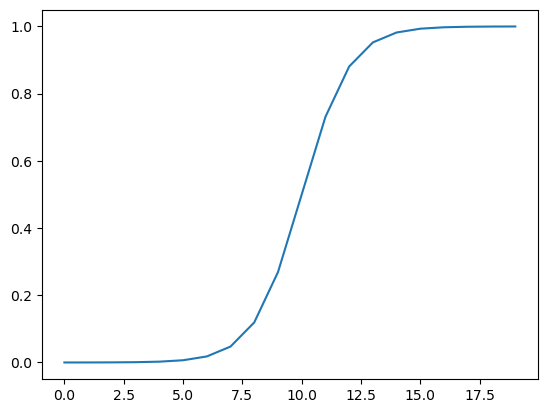

In [51]:
plt.plot(torch.sigmoid(A))

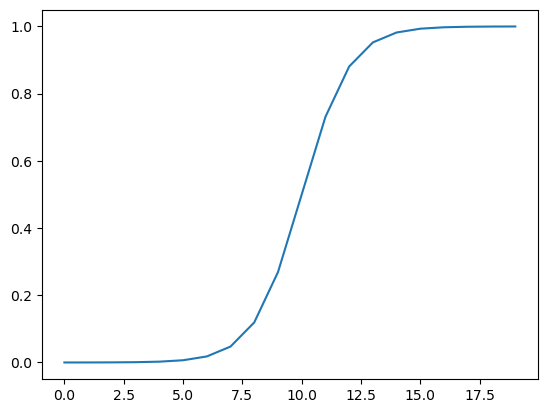

In [52]:
plt.plot(sigmoid(A))

# Putting it All Together (Part 1): Building a Multiclass Dataset

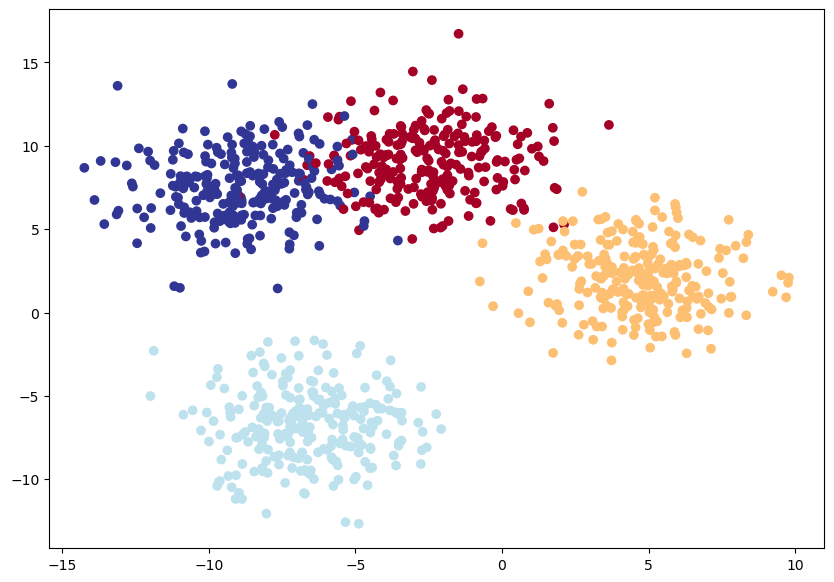

In [118]:
from sklearn.datasets import make_blobs

#hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=2,
                            random_state=RANDOM_SEED)

#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

#Train-Test Splits
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

# Creating a Multi-Class Classification Model with PyTorch

In [55]:
#Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [119]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.
        
        Args:
            input_features(int): Number of input features to the model.
            output_features(int): Number of output classes of the model.
            hidden_units(int): Number of hidden units between layers (default is 8).
            
        Returns:
        
        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
    
#Create instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

# Setting Up a Loss Function & Optimizer for our Multi-Class Model

In [120]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

# Logits to Prediction Probabilities to Prediction Labels with a Multi-Class Model

In [61]:
model_4(X_blob_test).shape #This model's raw outputs are logits

torch.Size([200, 4])

In [66]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10] #These are the logits (log-odds) of each obs belonging to each of the four output classes

tensor([[ 0.7502, -0.5664,  0.3349, -0.2461],
        [-0.3162, -1.7475, -0.3072, -1.1094],
        [ 0.1551, -0.8605,  0.3147, -0.9017],
        [ 0.4327, -0.4324,  0.2350, -0.1933],
        [ 0.9230, -0.9330,  0.3317, -0.5008],
        [-0.5137, -2.0522, -0.4146, -1.3576],
        [ 0.3226, -0.8675,  0.2519, -0.8838],
        [ 0.6924, -1.1004,  0.2131, -0.6349],
        [ 0.3641, -1.0655,  0.4944, -1.1882],
        [ 0.8084, -0.9803,  0.2900, -0.5620]])

In [71]:
#Convert model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
# Predicted probabilities of each obs belonging to each of the four output classes
print(f"Logits:\n {y_logits[:5]}")
print(f"\nPrediction Probabilities:\n {y_pred_probs[:5]}")
print(f"\nNote that each row above sums to 1.")

Logits:
 tensor([[ 0.7502, -0.5664,  0.3349, -0.2461],
        [-0.3162, -1.7475, -0.3072, -1.1094],
        [ 0.1551, -0.8605,  0.3147, -0.9017],
        [ 0.4327, -0.4324,  0.2350, -0.1933],
        [ 0.9230, -0.9330,  0.3317, -0.5008]])

Prediction Probabilities:
 tensor([[0.4353, 0.1167, 0.2873, 0.1607],
        [0.3703, 0.0885, 0.3737, 0.1675],
        [0.3469, 0.1256, 0.4069, 0.1206],
        [0.3602, 0.1516, 0.2956, 0.1926],
        [0.5126, 0.0801, 0.2838, 0.1234]])

Note that each row above sums to 1.


In [72]:
y_pred_probs[0] #1st obs log-odds of belonging to each of the 4 output classes

tensor([0.4353, 0.1167, 0.2873, 0.1607])

In [73]:
torch.max(y_pred_probs[0]) #1st obs highest predicted probability

tensor(0.4353)

In [74]:
torch.argmax(y_pred_probs[0]) # Class 0 has the highest predicted probability for the 1st obs

tensor(0)

In [76]:
#Putting it all together (logits -> predicted probabilities -> predicted labels)
y_preds = torch.argmax(torch.softmax(model_4(X_blob_test), dim=1), dim=1)
print(f"First 5 Prediction Labels:\n{y_preds[:5]}")

First 5 Prediction Labels:
tensor([0, 2, 2, 0, 0])


# Training a Multi-Class Classification Model

In [121]:
#Training & Testing Loop
torch.manual_seed(42)

#Move data to device
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

#Train
epochs = 100

for epoch in range(epochs):
    model_4.train()
    
    #1. Forward Pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    #2. Calculate loss
    loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor))
    acc  = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Loss backward (backpropagation)
    loss.backward()
    
    #5. Optimizer step (gradient descent)
    optimizer.step()
    
    ##Testing
    model_4.eval()
    with torch.inference_mode():
        #1. Forward Pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        #2. Calculate loss
        test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor))
        test_acc  = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
        
    #Print current values
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.16741 | Acc: 40.50% | Test Loss: 1.08563 | Test acc: 50.00%
Epoch: 5 | Loss: 0.83330 | Acc: 87.38% | Test Loss: 0.83171 | Test acc: 88.50%
Epoch: 10 | Loss: 0.68131 | Acc: 92.88% | Test Loss: 0.69426 | Test acc: 92.00%
Epoch: 15 | Loss: 0.57337 | Acc: 94.50% | Test Loss: 0.58395 | Test acc: 95.00%
Epoch: 20 | Loss: 0.47821 | Acc: 94.62% | Test Loss: 0.48371 | Test acc: 95.50%
Epoch: 25 | Loss: 0.39689 | Acc: 94.88% | Test Loss: 0.39648 | Test acc: 97.00%
Epoch: 30 | Loss: 0.32163 | Acc: 95.88% | Test Loss: 0.31335 | Test acc: 97.00%
Epoch: 35 | Loss: 0.24420 | Acc: 96.00% | Test Loss: 0.23007 | Test acc: 97.00%
Epoch: 40 | Loss: 0.18300 | Acc: 96.12% | Test Loss: 0.16929 | Test acc: 96.50%
Epoch: 45 | Loss: 0.14923 | Acc: 96.12% | Test Loss: 0.13675 | Test acc: 96.50%
Epoch: 50 | Loss: 0.13164 | Acc: 96.25% | Test Loss: 0.11941 | Test acc: 96.50%
Epoch: 55 | Loss: 0.12150 | Acc: 96.25% | Test Loss: 0.10916 | Test acc: 96.50%
Epoch: 60 | Loss: 0.11502 | Acc: 96.25% | 

# Making Predictions with & Evaluating our Multi-Class Classification Model

In [123]:
#Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
#View first 10 predictions
y_logits[:10]

tensor([[  0.0115,   6.0601,  -8.4093,  -8.4163],
        [ -1.4769,  -6.0067,  -4.1702,   2.5993],
        [ -3.3982,  -3.7515,   3.1081,  -2.6314],
        [ -1.0987,   4.1476,  -3.5406,  -4.2915],
        [  3.7035,  -1.0898, -10.0379,  -6.3261],
        [ -2.0053,  -7.4626,  -5.2498,   3.4261],
        [ -2.9233,  -3.0336,   2.7233,  -2.0891],
        [  2.8830,  -4.4700,  -7.1183,  -2.5822],
        [ -4.5562,  -5.1398,   3.8900,  -3.6046],
        [  3.3123,  -3.2114,  -7.8873,  -3.7766]])

In [124]:
#Logits -> Prediction Probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.3556e-03, 9.9764e-01, 5.1879e-07, 5.1516e-07],
        [1.6666e-02, 1.7971e-04, 1.1276e-03, 9.8203e-01],
        [1.4854e-03, 1.0433e-03, 9.9427e-01, 3.1980e-03],
        [5.2357e-03, 9.9409e-01, 4.5550e-04, 2.1496e-04],
        [9.9174e-01, 8.2164e-03, 1.0680e-06, 4.3712e-05],
        [4.3570e-03, 1.8583e-05, 1.6986e-04, 9.9545e-01],
        [3.4778e-03, 3.1147e-03, 9.8540e-01, 8.0098e-03],
        [9.9511e-01, 6.3754e-04, 4.5122e-05, 4.2110e-03],
        [2.1453e-04, 1.1968e-04, 9.9911e-01, 5.5558e-04],
        [9.9769e-01, 1.4648e-03, 1.3647e-05, 8.3236e-04]])

In [130]:
#Prediction Probabilities -> Prediction Labels
y_preds = torch.argmax(y_pred_probs, dim=1)
print(f"First 10 predicted classes on test data:\n{y_preds[:10]}")
print(f"\nFirst 10 true classes of test data:\n{y_blob_test[:10]}")

First 10 predicted classes on test data:
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

First 10 true classes of test data:
tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])


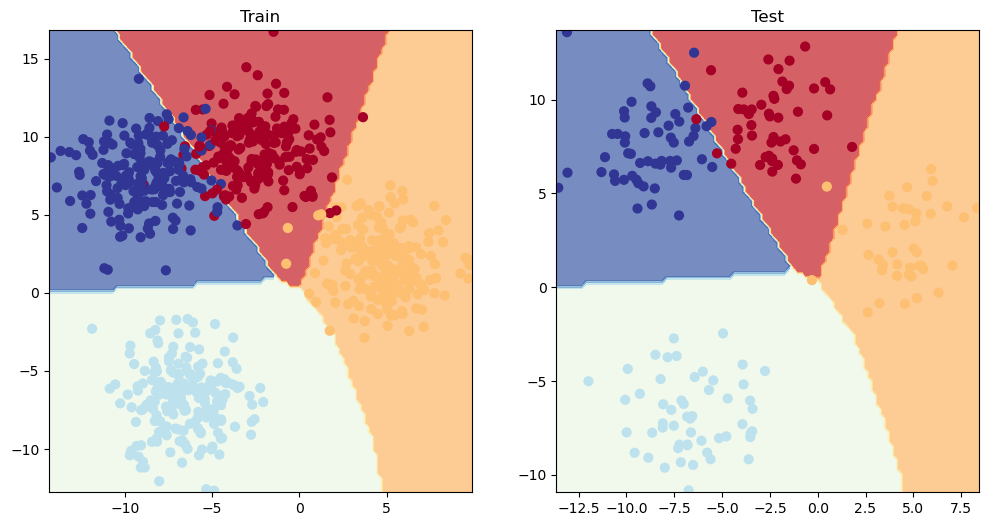

In [122]:
#plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# Discussing a few more Classification Metrics

In [131]:
#Accuracy = number of correct predictions / total number of predictions ##good for balanced classes
    #torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()
    
#Precision = number of true positives / (number of true positives + number of false positives)
#Higher precision -> less false positives
    #torchmetrics.Precision() or sklearn.metrics.precision_score()
    
#Recall = number of true positives / (number of true positives + number of false negatives)
#Higher recall -> less false negatives
    #torchmetrics.Recall() or sklearn.metrics.recall_score()
    
#F1 Score = harmonic mean of precision & recall = 2 * ((precision * recall)/(precision + recall))
    #torchmetrics.F1Score() or sklearn.metrics.f1_score()
    
#Confusion matrix 
    #torchmetrics.ConfusionMatrix()
    
#Classification report

In [134]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_blob_test, y_preds))
print(confusion_matrix(y_blob_test, y_preds))
#7 misclassifications out of 200 test samples = 96.5% overall accuracy

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        49
         1.0       1.00      0.95      0.97        41
         2.0       0.98      1.00      0.99        53
         3.0       0.96      0.95      0.96        57

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.97       200
weighted avg       0.97      0.96      0.97       200

[[47  0  0  2]
 [ 1 39  1  0]
 [ 0  0 53  0]
 [ 3  0  0 54]]


In [142]:
from torchmetrics import Accuracy
tmAccuracy = Accuracy('multiclass', num_classes=4).to(device)
tmAccuracy(y_preds, y_blob_test)

tensor(0.9650)

In [144]:
from torchmetrics import Precision
tmPrecision = Precision('multiclass', num_classes=4).to(device)
tmPrecision(y_preds, y_blob_test)

tensor(0.9650)